In [2]:
! pip install scanpy leidenalg python-igraph louvain

1. Reading the data

2. QC & Preprocessing

3. Manifold embedding & clustering based on transcriptional similarity

4. Visualization

In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         7.1.2
astor                       0.8.1
bottleneck                  1.3.2
cached_property             1.5.2
cffi                        1.14.6
cloudpickle                 1.3.0
cycler                      0.10.0
cython_runtime              NA
dask                        2.12.0
dateutil                    2.8.2
debugpy                     1.0.0
decorator                   4.4.2
google                      NA
h5py      

In [4]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

  0%|          | 0.00/7.86M [00:00<?, ?B/s]

  0%|          | 0.00/29.3M [00:00<?, ?B/s]

reading /content/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:
adata

AnnData object with n_obs × n_vars = 4035 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

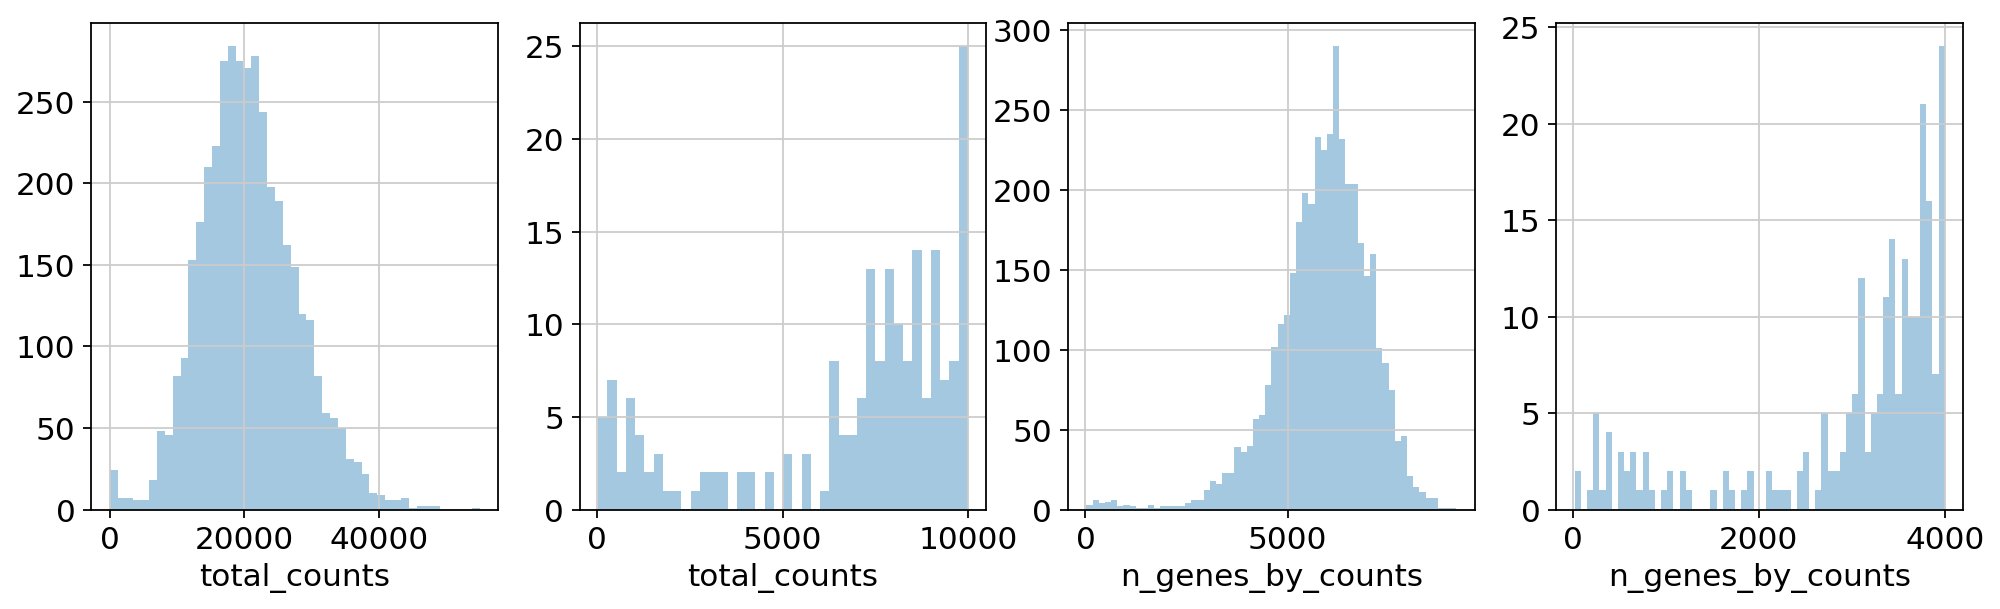

In [6]:
# QC & preprocessing
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs['total_counts'], kde=False, ax=axs[0])
sns.distplot(adata.obs['total_counts'][adata.obs['total_counts'] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts'] < 4000], kde=False, bins=60, ax=axs[3])

In [7]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 44 cells that have less than 5000 counts
filtered out 130 cells that have more than 35000 counts
#cells after MT filter: 3861
filtered out 16916 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


In [8]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [9]:
# Manifold embedding and clustering based on transcriptional similarity
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 10 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


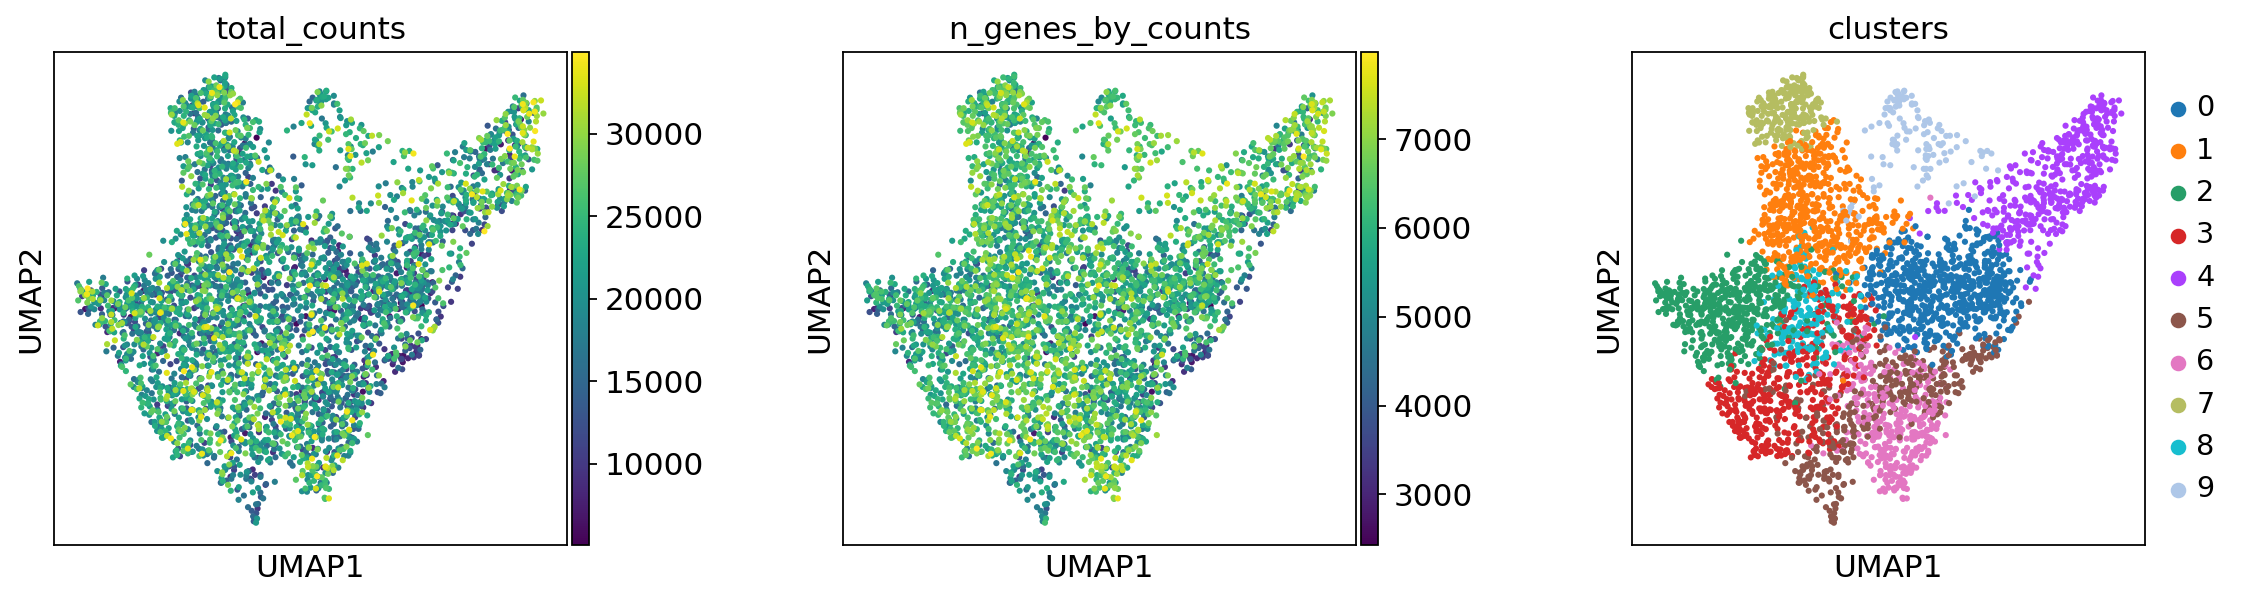

In [10]:
# plot some covariates to check if there's any particular structure in the UMAP associated w/ total counts and detected genes
plt.rcParams['figure.figsize'] = (4, 4)
sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts', 'clusters'], wspace=0.4)

In [12]:
# Visualization in spatial coordinates: overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided
plt.rcParams['figure.figsize'] = (8, 8)
sc.pl.spatial(adata, img_key='hires', color=['total_counts', 'n_genes_by_counts'])

Output hidden; open in https://colab.research.google.com to view.

The function sc.pl.spatial accepts 4 additional parameters:

- `img_key`: key where the img is stored in the adata.uns element

- `crop_coord`: coordinates to use for cropping (left, right, top, bottom)

- `alpha_img`: alpha value for the transcparency of the image

- `bw`: flag to convert the image into gray scale

Furthermore, in sc.pl.spatial, the `size` parameter changes its behaviour: it becomes a scaling factor for the spot sizes.

Before, we performed clustering in gene expression space, and visualized the results with UMAP. By visualizing clustered samples in spatial dimensions, we can gain insights into tissue organization and, potentially, into inter-cellular communication.

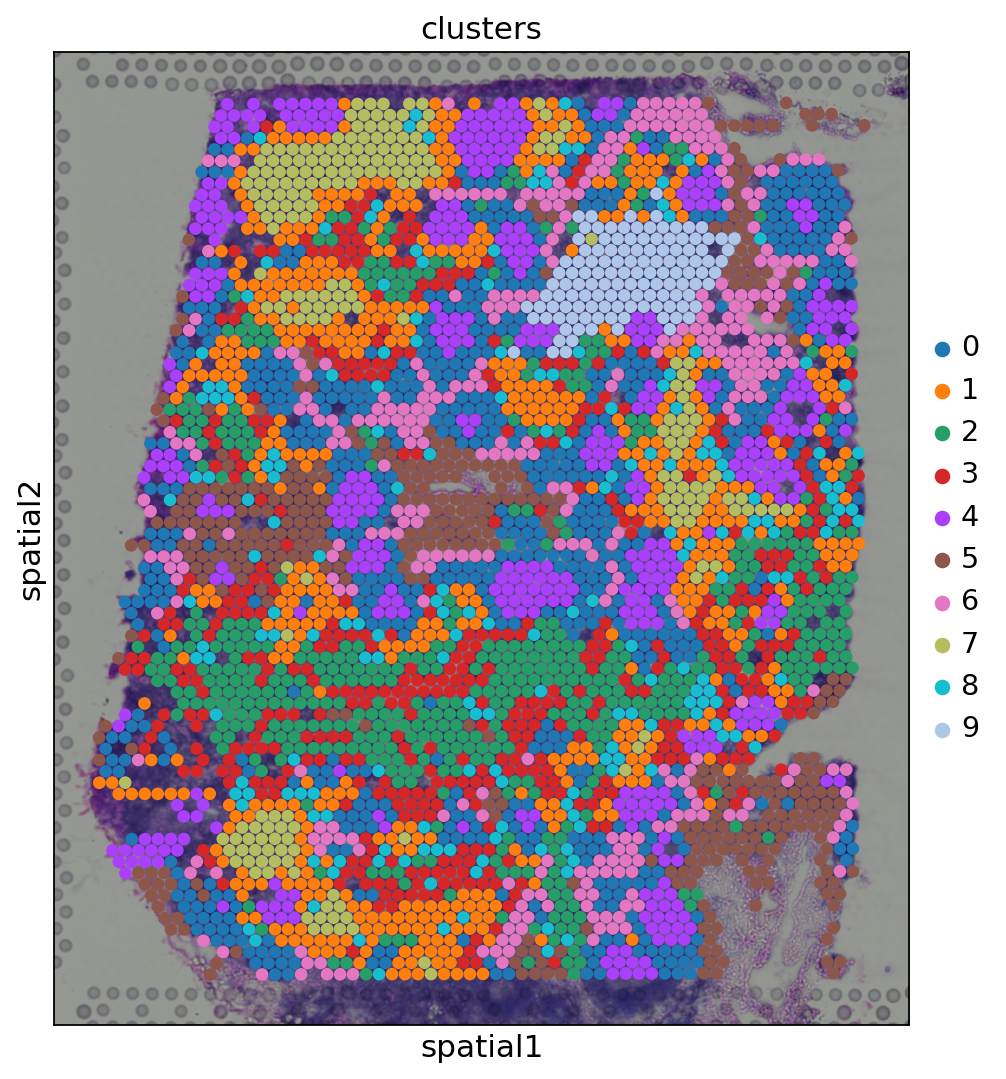

In [13]:
sc.pl.spatial(adata, img_key='hires', color='clusters', size=1.5)

Spots belonging to the same cluster in gene expression space often co-occur in spatial dimensions. For instance, spots belonging to cluster 5 are often surrounded by spots belonging to cluster 0.

We can zoom in specific regions of interests to gain qualitative insights. Furthermore, by changing the alpha values of the spots, we can visualize better the underlying tissue morphology from the H&E image.

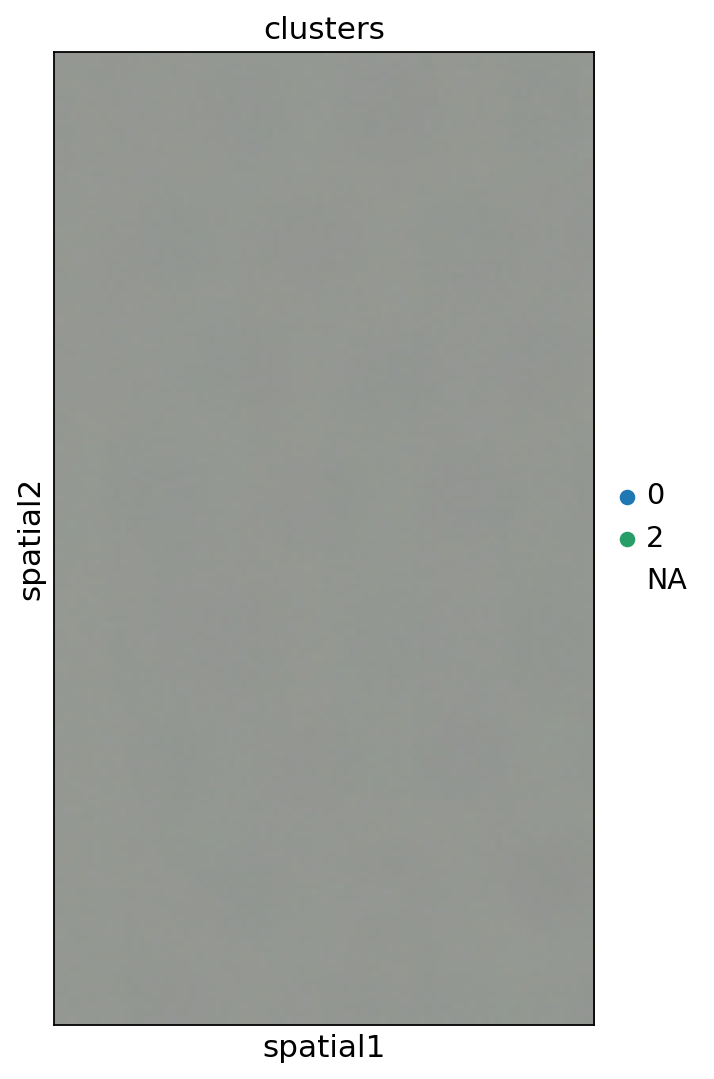

In [17]:
sc.pl.spatial(adata, img_key="hires", color="clusters", groups=["0", "2"], crop_coord=[1200, 1700, 1900, 1000], alpha=0.5, size=1.3)


ranking genes


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`
categories: 0, 1, 2, etc.
var_group_labels: 5


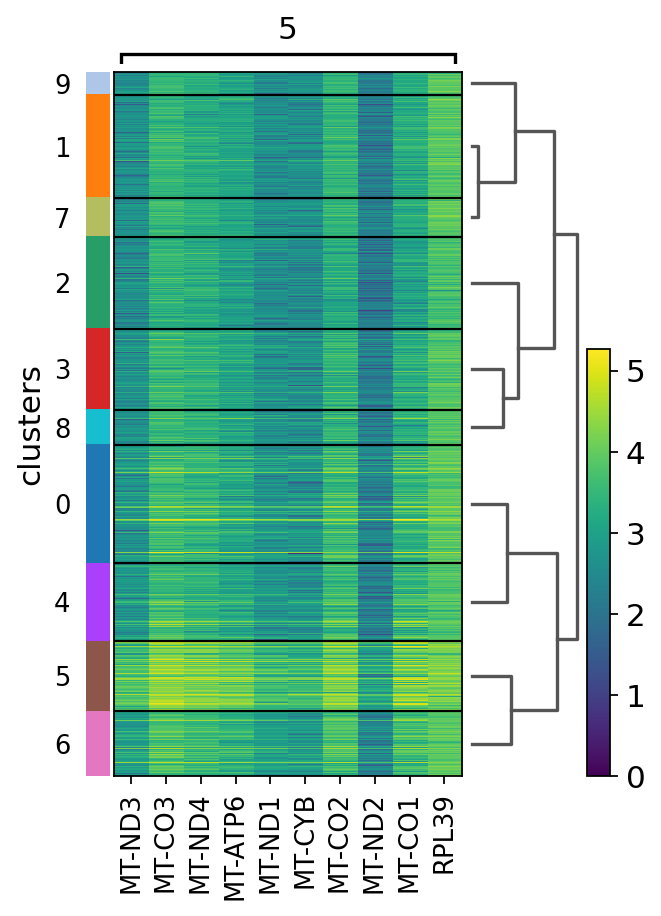

In [15]:
# Cluster marker genes
sc.tl.rank_genes_groups(adata, 'clusters', method='t-test')
sc.pl.rank_genes_groups_heatmap(adata, groups='5', n_genes=10, groupby='clusters')

In [18]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "CR2"])

Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Spatially variable genes
# investigates how gene expression trends varies in space, thus identifying spatial patterns of gene expression

! pip install spatialde

  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5713 sha256=3003fc48055e69a9d72b9bcfb0c9de907f3833f7b650afed5d430d563b3b3784
  Stored in directory: /root/.cache/pip/wheels/32/32/4d/28db4e878adcfff8255ae5745681cbb19cf2ea65a637a3e6b1
Successfully built NaiveDE


In [20]:
import SpatialDE

In [21]:
%%time
counts = pd.DataFrame(adata.X.todense(), columns=adata.var_names, index=adata.obs_names)
coord = pd.DataFrame(adata.obsm['spatial'], columns=['x_coord', 'y_coord'], index=adata.obs_names)
results = SpatialDE.run(coord, counts)

/usr/local/lib/python3.7/dist-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/usr/local/lib/python3.7/dist-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/SpatialDE/base.py:178: RuntimeWarning: divide by zero encountered in double_scalars
  s2_logdelta = 1. / (derivative(LL_obj, np.log(max_delta), n=2) ** 2)


  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

  0%|          | 0/19685 [00:00<?, ?it/s]

CPU times: user 1h 26min 20s, sys: 20min, total: 1h 46min 21s
Wall time: 57min 38s


In [22]:
results.index = results["g"]
adata.var = pd.concat([adata.var, results.loc[adata.var.index.values, :]], axis=1)

In [23]:
results.sort_values("qval").head(10)

,FSV,M,g,l,max_delta,max_ll,max_mu_hat,max_s2_t_hat,model,n,s2_FSV,s2_logdelta,time,BIC,max_ll_null,LLR,pval,qval
g,,,,,,,,,,,,,,,,,,
ZAP70,0.174285,4,ZAP70,474.158722,4.646835,-3147.260465,1.275739,0.082194,SE,3861,0.000012,0.000582,0.005470,6327.555656,-3377.520706,230.260241,0.0,0.0
IFIT2,0.174397,4,IFIT2,474.158722,4.643228,-797.410268,0.135497,0.017972,SE,3861,0.000010,0.000479,0.005715,1627.855261,-1069.267706,271.857438,0.0,0.0
PARP9,0.070539,4,PARP9,474.158722,12.923702,-3059.644954,0.714529,0.027378,SE,3861,0.000009,0.001730,0.016196,6152.324634,-3132.122797,72.477843,0.0,0.0
UBE2L6,0.067534,4,UBE2L6,474.158722,13.542412,-3120.888857,0.834150,0.029245,SE,3861,0.000007,0.001468,0.016740,6274.812441,-3198.517547,77.628689,0.0,0.0
IGFBP5,0.121768,4,IGFBP5,474.158722,7.073993,-3184.109455,0.652525,0.046252,SE,3861,0.000014,0.001134,0.004911,6401.253637,-3296.781120,112.671664,0.0,0.0
MT-ND5,0.139338,4,MT-ND5,474.158722,6.058324,-3194.347591,1.086134,0.063269,SE,3861,0.000008,0.000540,0.005292,6421.729909,-3427.656221,233.308629,0.0,0.0
GRASP,0.221837,4,GRASP,130.547421,3.503161,-3277.732098,0.819272,0.144317,SE,3861,0.000005,0.000166,0.006679,6588.498922,-3368.474078,90.741980,0.0,0.0
CR2,0.665211,4,CR2,248.797504,0.500596,-3160.920956,2.146658,0.626317,SE,3861,0.000002,0.000037,0.004385,6354.876638,-4445.621003,1284.700047,0.0,0.0
TCF7,0.319212,4,TCF7,248.797504,2.121330,-3166.384288,1.405058,0.204397,SE,3861,0.000003,0.000069,0.006852,6365.803303,-3676.603243,510.218955,0.0,0.0


In [24]:
sc.pl.spatial(adata, img_key="hires", color=["COL1A2", "SYPL1"], alpha=0.7)


Output hidden; open in https://colab.research.google.com to view.

In [27]:
# MERFISH Example
import urllib.request
url_coord = "https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/15/pnas.1912459116.sd15.xlsx"
filename_coord = "pnas.1912459116.sd15.xlsx"
urllib.request.urlretrieve(url_coord, filename_coord)

('pnas.1912459116.sd15.xlsx', <http.client.HTTPMessage at 0x7f8a08473b90>)

In [28]:
url_counts = "https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/12/pnas.1912459116.sd12.csv"
filename_counts = "pnas.1912459116.sd12.csv"
urllib.request.urlretrieve(url_counts, filename_counts)

('pnas.1912459116.sd12.csv', <http.client.HTTPMessage at 0x7f8a08566210>)

In [29]:
coordinates = pd.read_excel("./pnas.1912459116.sd15.xlsx", index_col=0)
counts = sc.read_csv("./pnas.1912459116.sd12.csv").transpose()

In [30]:
adata_merfish = counts[coordinates.index, :]
adata_merfish.obsm["spatial"] = coordinates.to_numpy()

In [31]:
sc.pp.normalize_per_cell(adata_merfish, counts_per_cell_after=1e6)
sc.pp.log1p(adata_merfish)
sc.pp.pca(adata_merfish, n_comps=15)
sc.pp.neighbors(adata_merfish)
sc.tl.umap(adata_merfish)
sc.tl.leiden(adata_merfish, key_added="clusters", resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA
    with n_comps=15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 7 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


In [32]:
adata_merfish

AnnData object with n_obs × n_vars = 645 × 12903
    obs: 'n_counts', 'clusters'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

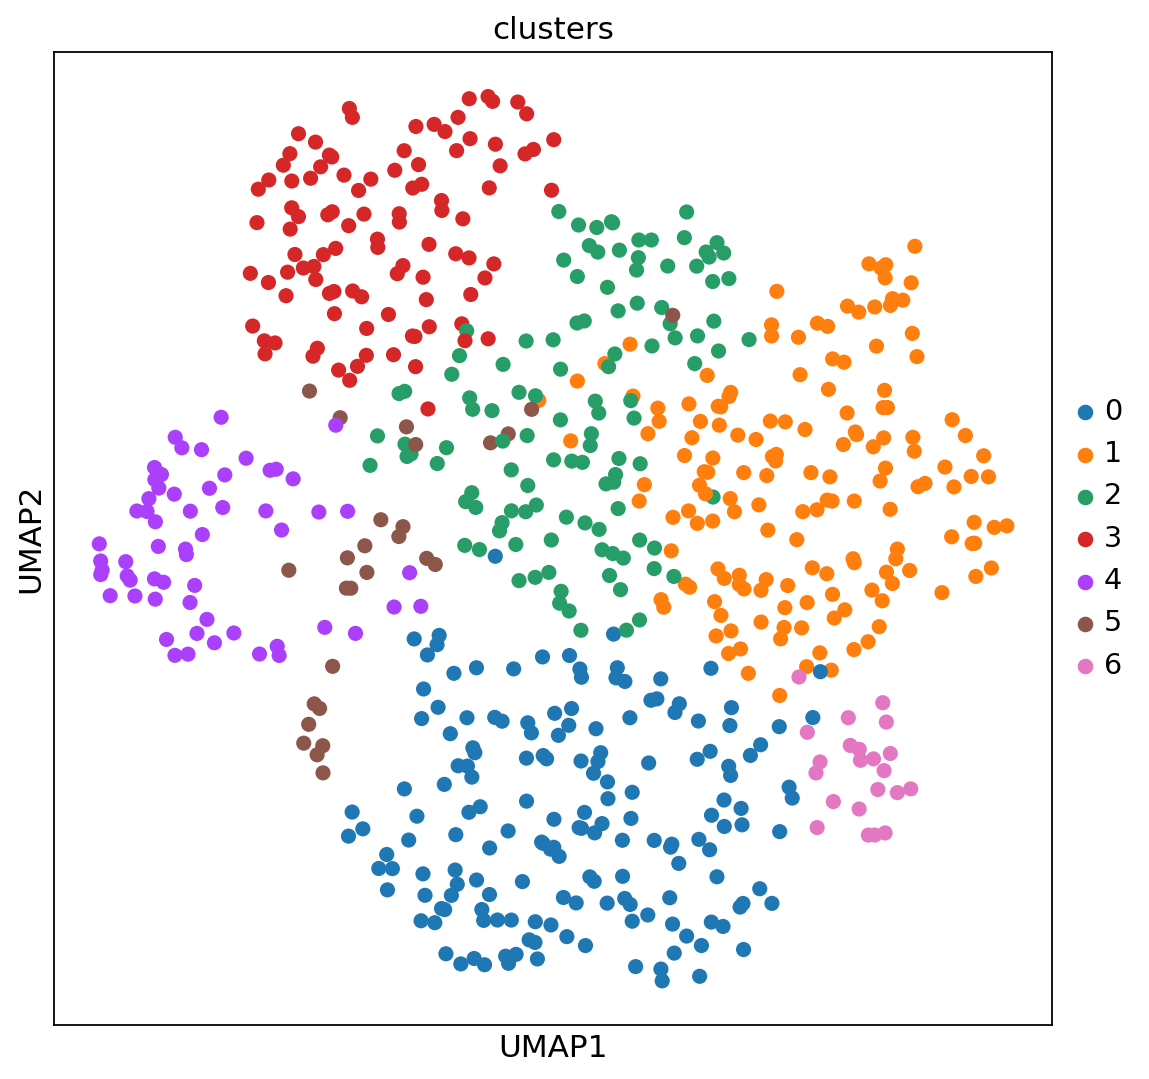

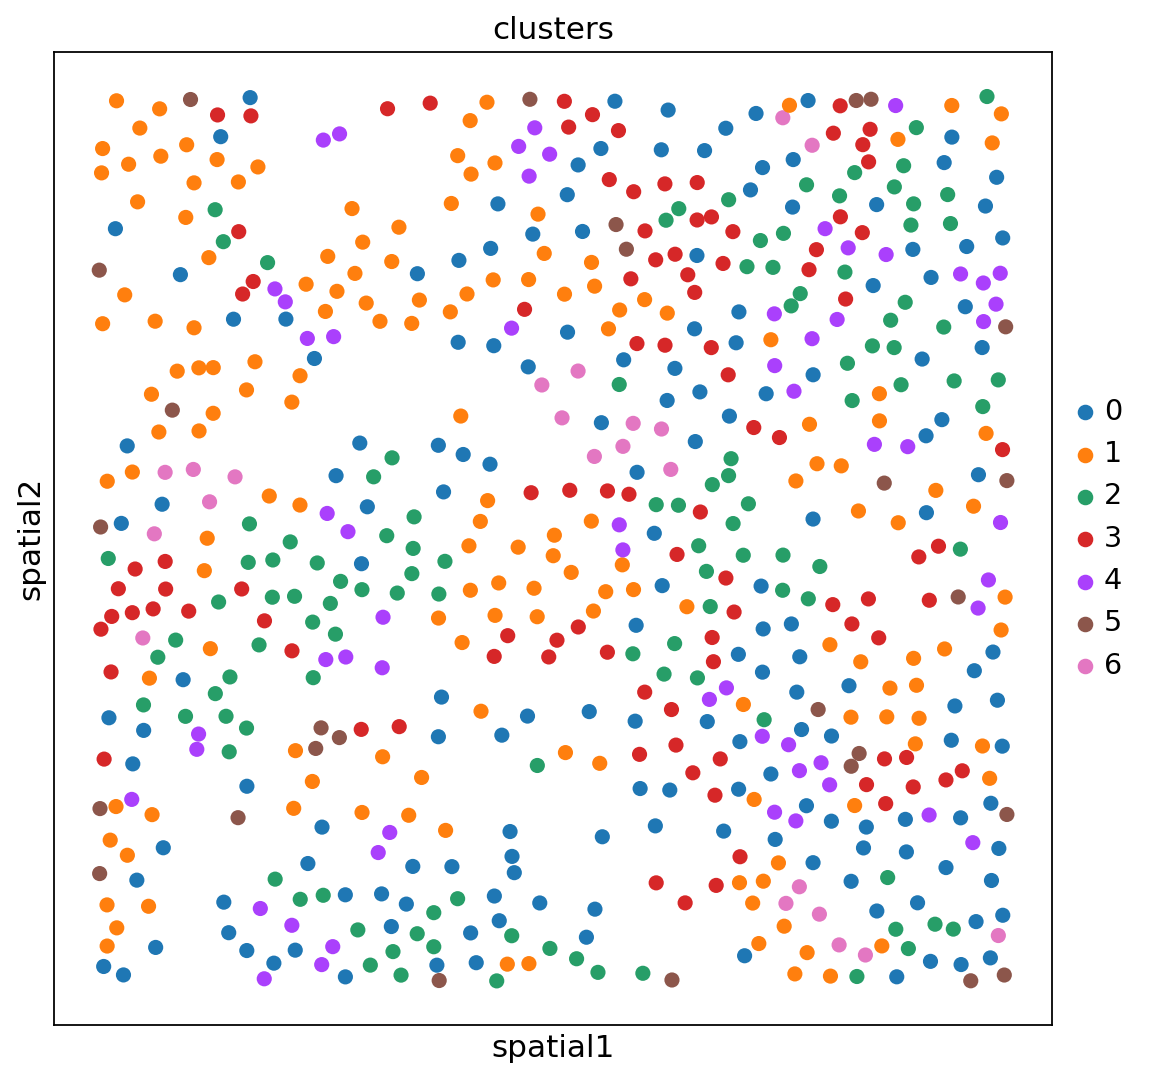

In [33]:
sc.pl.umap(adata_merfish, color='clusters')
sc.pl.embedding(adata_merfish, basis='spatial', color='clusters')